In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\Ajay\Desktop\Inno_Projects\Tamil_Sign_Language\Datasett", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 13721 files [01:49, 124.96 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
13 folder and 0 images in output\test
0 folder and 59 images in output\test\1
0 folder and 60 images in output\test\10
0 folder and 57 images in output\test\11
0 folder and 62 images in output\test\12
0 folder and 60 images in output\test\13
0 folder and 61 images in output\test\2
0 folder and 61 images in output\test\3
0 folder and 60 images in output\test\4
0 folder and 58 images in output\test\5
0 folder and 59 images in output\test\6
0 folder and 62 images in output\test\7
0 folder and 58 images in output\test\8
0 folder and 61 images in output\test\9
13 folder and 0 images in output\train
0 folder and 816 images in output\train\1
0 folder and 810 images in output\train\10
0 folder and 803 images in output\train\11
0 folder and 821 images in output\train\12
0 folder and 811 images in output\train\13
0 folder and 816 images in output\train\2
0 folder and 813 images in output\train\3
0 folder and 811 images in output\train\4
0 folder and 806 images in 

In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (480, 640, 3)


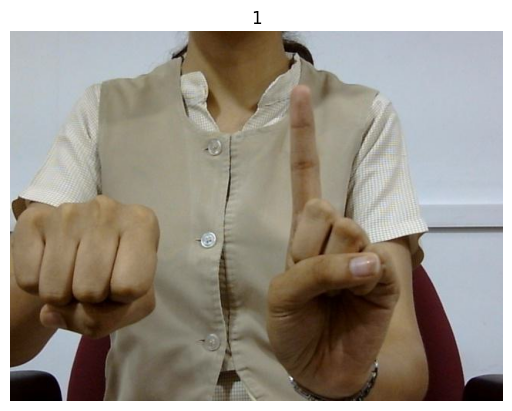

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='1')

In [8]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [9]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 10541 images belonging to 13 classes.
Found 2989 images belonging to 13 classes.
Found 778 images belonging to 13 classes.


In [10]:
train_data.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12}

In [11]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [12]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (10541,)
val_y.shape:  (2989,)
test_y.shape:  (778,)


In [13]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

# Navigate to YOLOv5 directory and install requirements
!pip install -r yolov5/requirements.txt


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [14]:
import torch
from torchvision.models import vgg16, resnet50, inception_v3

def load_yolov5_with_backbone(backbone_name):
    # Load YOLOv5 model
    yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt', autoshape=False)

    # Replace the backbone
    if backbone_name == 'vgg16':
        backbone = vgg16(pretrained=True).features
    elif backbone_name == 'resnet50':
        backbone = resnet50(pretrained=True).layer1
    elif backbone_name == 'inceptionv3':
        backbone = inception_v3(pretrained=True).Conv2d_1a_3x3
    else:
        raise ValueError("Unsupported backbone")

    # Assign new backbone to YOLOv5
    yolo_model.model.model[0] = backbone
    return yolo_model


In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Ensure train_data is a PyTorch DataLoader
# Apply transformations if needed
train_data = DataLoader(
    dataset,  # Replace with your dataset
    batch_size=32,  # Adjust batch size
    shuffle=True
)

backbone_names = ['vgg16', 'resnet50', 'inceptionv3']
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for backbone_name in backbone_names:
    print(f"Loading YOLOv5 with {backbone_name} backbone...")
    model = load_yolov5_with_backbone(backbone_name)  # Ensure this function integrates backbone properly
    model = model.to(device)  # Move the model to the specified device
    model.train()  # Set the model to training mode

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(15):  # Train for 15 epochs
        print(f"Epoch {epoch+1}/15")
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_data:  # Assume train_data is a DataLoader
            # Convert numpy arrays to PyTorch tensors
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Ensure outputs and labels are compatible
            if isinstance(outputs, tuple):  # Handle multiple outputs from YOLO
                outputs = outputs[0]

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {train_accuracy:.2f}%")

    # Save model weights
    model_save_path = f"yolov5_{backbone_name}_weights.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Weights saved to {model_save_path}")

    # Validation (Placeholder logic)
    val_accuracy = train_accuracy  # Replace with actual validation logic
    results[backbone_name] = {'train_accuracy': train_accuracy, 'val_accuracy': val_accuracy}

# Print results
print("\nFinal Results:")
for backbone_name, metrics in results.items():
    print(f"Backbone: {backbone_name}, Train Accuracy: {metrics['train_accuracy']:.2f}%, Validation Accuracy: {metrics['val_accuracy']:.2f}%")


NameError: name 'dataset' is not defined